In [226]:

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, concatenate
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [131]:
import tensorflow as tf

In [122]:
from keras.utils import to_categorical

In [25]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, _), (_, _) = mnist.load_data(path="./mnist_data")
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
        if epoch % sample_interval == 0:
            self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


In [26]:
gan = GAN()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

##  GAN

In [80]:
gan.train(epochs=5000, batch_size=64, sample_interval=1000)

4999 [D loss: 0.735583, acc.: 48.44%] [G loss: 0.838254]


## Inspect results

In [279]:
def show_generated_image(gan, input_class= None):
    
    gen_model = gan.generator
    noise = np.random.uniform(-1,1,(1, gan.latent_dim))
    net_input = noise 
    if input_class:
        label = to_categorical(input_class, num_classes=10).reshape(1,-1)
        net_input = [noise, label]
    
    
    img = gen_model.predict(net_input)
    img = 0.5 * img + 0.5
    plt.figure(figsize=(8,6))
    plt.imshow(img[0,:,:,0],cmap='gray')

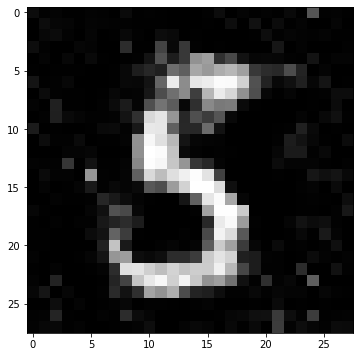

In [280]:
show_generated_image(gan)

## WITH iNPUTS

In [237]:
class GAN_WITH_INPUTS():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.num_classes = 10
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        self.combined = self.build_generator_discriminator(self.generator, self.discriminator)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator_discriminator(self, generator, discriminator):
        num_classes=None,
        z = Input(shape=(self.latent_dim,))
        class_input = Input(shape=(self.num_classes,))
        
        img = generator([z, class_input])
        discriminator.trainable = False
        label = discriminator(img)
        return Model([z, class_input], label)
    
    def build_generator(self):

        model = Sequential()
        
        noise = Input(shape=(self.latent_dim,), name="noise" )
        digit_class = Input(shape=(self.num_classes,), name="class")
        input_layer = concatenate([noise, digit_class])

#         model.add(Dense(256, input_shape=(self.latent_dim+self.num_classes,))
        x = Dense(256, activation=LeakyReLU(alpha=0.2))(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
        x = BatchNormalization(momentum=0.8)(x)
        img = Dense(np.prod(self.img_shape), activation='tanh')(x)
        img = Reshape(self.img_shape)(img)

        model = Model([noise, digit_class], img)
        model.summary()
        
        return model

    def build_discriminator(self):
        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.num_classes, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, Y_train), (_, _) = mnist.load_data(path="./mnist_data")
        Y_train= to_categorical(Y_train)
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        
        fake = np.zeros((batch_size, self.num_classes))

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            true_digit_classes = Y_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            g_loss = self.combined.train_on_batch([noise, true_digit_classes], true_digit_classes)
            gen_imgs = self.generator.predict([noise, true_digit_classes])
            d_loss_real = self.discriminator.train_on_batch(imgs, true_digit_classes)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))        

In [238]:
gan_with_inputs = GAN_WITH_INPUTS()

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_45 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_307 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_199 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_308 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_200 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_309 (Dense)            (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_______________________________________________

In [239]:
gan_with_inputs.train(epochs=5000, batch_size=64, sample_interval=1000)

4999 [D loss: 0.080749, acc.: 53.91%] [G loss: 0.093364]


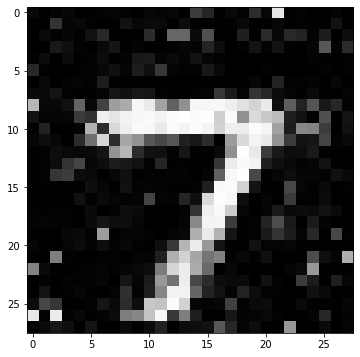

In [293]:
show_generated_image(gan_with_inputs, 7)